In [1]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV, LinearRegression,
                                  MultiTaskElasticNet, MultiTaskElasticNetCV)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
## 导入相关库 ##
## 请检查你已经安装了所有库，如果有配置问题请随时call我
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
ox.config(use_cache = True, log_console = False)

In [3]:
src = rasterio.open('LongNTL_2020.tif')

In [4]:
data = pd.read_csv("./LightPollution/Paris_final.csv")
data = gpd.GeoDataFrame(
    data.loc[:, [c for c in data.columns if c != "geometry"]],
    geometry = gpd.GeoSeries.from_wkt(data["geometry"]),
    crs="EPSG:4326")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)
data

,barrier,addr:city,amenity,name,operator,wheelchair,source,foot,created_by,bicycle,...,industrial_mean_distance,industrial_mean_NTL,residential_mean_distance,residential_mean_NTL,retail_mean_distance,retail_mean_NTL,Over_illumination,Trespass,Clutter,geometry
0,NaN,NaN,NaN,NaN,NaN,NaN,cadastre-dgi-fr source : Direction Generale de...,NaN,NaN,NaN,...,2086.943438,59.777496,1573.387518,53.984997,NaN,NaN,40370.980469,6.269747,0.003324,POINT (2.30350 48.81872)
1,NaN,NaN,NaN,NaN,NaN,NaN,cadastre-dgi-fr source : Direction Generale de...,NaN,NaN,NaN,...,2081.926765,59.777496,1571.910093,53.984997,NaN,NaN,40287.148438,6.287956,0.003320,POINT (2.30365 48.81868)
2,NaN,NaN,NaN,NaN,NaN,NaN,survey,NaN,NaN,NaN,...,2105.945409,59.777496,1554.027126,52.763847,NaN,NaN,39751.296875,6.151422,0.003264,POINT (2.30295 48.81884)
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2093.866033,59.777496,1578.017912,53.984997,NaN,NaN,40153.781250,6.230628,0.003294,POINT (2.30330 48.81876)
4,NaN,Vincennes,NaN,Les Estudines Les Académies de Vincennes,Les Estudines,NaN,NaN,NaN,NaN,NaN,...,321.430817,32.855000,1620.100572,30.462000,NaN,NaN,17149.953125,2.743757,0.002808,POINT (2.45671 48.84602)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1942.320727,36.479286,2906.543404,31.004412,760.793177,32.461666,10117.814453,1.024134,0.001896,"POLYGON ((2.46974 48.82728, 2.47059 48.82799, ..."
155,NaN,NaN,NaN,NaN,NaN,NaN,cadastre-dgi-fr source : Direction Générale de...,NaN,NaN,NaN,...,1910.943221,70.490494,3917.788015,45.349998,2677.484985,43.483337,27337.359375,3.622899,0.004341,"POLYGON ((2.38524 48.82480, 2.38563 48.82483, ..."
156,NaN,NaN,NaN,NaN,NaN,NaN,cadastre-dgi-fr source : Direction Générale de...,NaN,NaN,NaN,...,1782.205574,80.809998,3163.192949,47.181923,2681.721993,43.764999,28787.710938,3.793135,0.004377,"POLYGON ((2.36711 48.81716, 2.36712 48.81740, ..."
157,NaN,NaN,NaN,NaN,NaN,NaN,cadastre-dgi-fr source : Direction Générale de...,NaN,NaN,NaN,...,2217.091897,61.733326,2872.731253,48.257305,NaN,NaN,29840.218750,4.080224,0.003149,"POLYGON ((2.24259 48.81943, 2.24261 48.81958, ..."


In [5]:
features = ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL',
            'commercial', 'commercial_mean_distance', 'commercial_mean_NTL',
            'construction', 'construction_mean_distance', 'construction_mean_NTL',
            'farmland', 'farmland_mean_distance', 'farmland_mean_NTL',
            'forest', 'forest_mean_distance', 'forest_mean_NTL', 
            'grass',  'grass_mean_distance', 'grass_mean_NTL',
            'industrial', 'industrial_mean_distance', 'industrial_mean_NTL',
            'residential', 'residential_mean_distance', 'residential_mean_NTL', 
            'retail', 'retail_mean_distance', 'retail_mean_NTL']
len(features)

27

In [6]:
mean_val = data.mean()
data = data.fillna(mean_val)

In [7]:
data["Over_illumination"] = (data["Over_illumination"] - data["Over_illumination"].min()) / (data["Over_illumination"].max() - data["Over_illumination"].min())
data["Trespass"] = (data["Trespass"] - data["Trespass"].min()) / (data["Trespass"].max() - data["Trespass"].min())
data["Clutter"] = (data["Clutter"] - data["Clutter"].min()) / (data["Clutter"].max() - data["Clutter"].min())

In [8]:
data[["Over_illumination", "Trespass", "Clutter"]]

,Over_illumination,Trespass,Clutter
0,0.514776,0.619573,0.357338
1,0.513409,0.621688,0.356521
2,0.504673,0.605835,0.346664
3,0.511235,0.615031,0.351906
4,0.136209,0.210187,0.265199
...,...,...,...
154,0.021566,0.010530,0.102291
155,0.302292,0.312260,0.538964
156,0.325937,0.332026,0.545309
157,0.343095,0.365358,0.326074


In [11]:
data.to_csv("Paris.csv")

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['residential', 'residential_mean_distance', 'residential_mean_NTL']]].values)
T = scaler.fit_transform(data[['residential', 'residential_mean_distance', 'residential_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary.reset_index(inplace=True)

Summary["Treatment"] = "residential"

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.318,0.074,4.318,0.000,0.197,0.439,residential
1,0,Y1,0.195,0.082,2.390,0.017,0.061,0.330,residential
2,0,Y2,0.310,0.133,2.330,0.020,0.091,0.529,residential


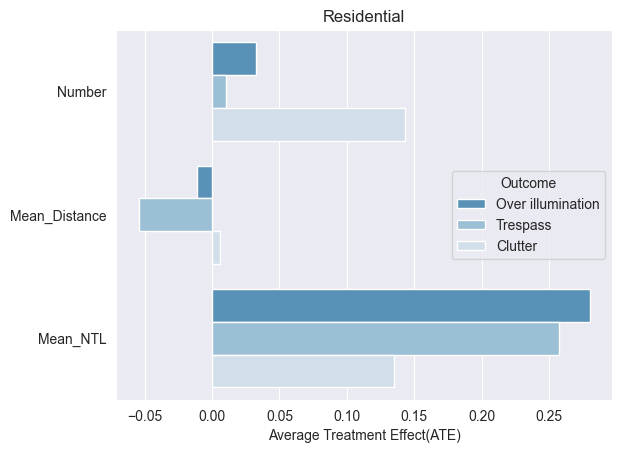

In [27]:
residential_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
residential_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
residential_effect = pd.melt(residential_effect, id_vars=["Treatment"], var_name = "Outcome")
residential_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = residential_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)
g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Residential")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("residential4.svg", bbox_inches = "tight")

In [15]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']]].values)
T = scaler.fit_transform(data[['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary.reset_index(inplace=True)

summary["Treatment"] = "commercial"
summary
Summary = pd.concat([Summary, summary], axis = 0)

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.318,0.074,4.318,0.000,0.197,0.439,residential
1,0,Y1,0.195,0.082,2.390,0.017,0.061,0.330,residential
2,0,Y2,0.310,0.133,2.330,0.020,0.091,0.529,residential
0,0,Y0,0.004,0.052,0.071,0.944,-0.081,0.089,commercial
1,0,Y1,-0.019,0.067,-0.281,0.779,-0.129,0.092,commercial
2,0,Y2,0.110,0.106,1.036,0.300,-0.064,0.284,commercial


In [16]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['retail', 'retail_mean_distance', 'retail_mean_NTL']]].values)
T = scaler.fit_transform(data[['retail', 'retail_mean_distance', 'retail_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "retail"
Summary = pd.concat([Summary, summary], axis = 0)
Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.318,0.074,4.318,0.000,0.197,0.439,residential
1,0,Y1,0.195,0.082,2.390,0.017,0.061,0.330,residential
2,0,Y2,0.310,0.133,2.330,0.020,0.091,0.529,residential
0,0,Y0,0.004,0.052,0.071,0.944,-0.081,0.089,commercial
1,0,Y1,-0.019,0.067,-0.281,0.779,-0.129,0.092,commercial
2,0,Y2,0.110,0.106,1.036,0.300,-0.064,0.284,commercial
0,0,Y0,0.016,0.035,0.456,0.649,-0.042,0.074,retail
1,0,Y1,-0.024,0.049,-0.491,0.624,-0.106,0.057,retail
2,0,Y2,0.137,0.090,1.530,0.126,-0.010,0.285,retail


In [22]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']]].values)
T = scaler.fit_transform(data[['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary2 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary2.reset_index(inplace=True)

Summary2["Treatment"] = "brownfield"
# Summary = pd.concat([Summary, summary], axis = 0)

Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,-0.089,0.052,-1.705,0.088,-0.174,-0.003,brownfield
1,0,Y1,-0.139,0.056,-2.485,0.013,-0.232,-0.047,brownfield
2,0,Y2,-0.018,0.105,-0.171,0.864,-0.191,0.155,brownfield


In [23]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['construction', 'construction_mean_distance', 'construction_mean_NTL',]]].values)
T = scaler.fit_transform(data[['construction', 'construction_mean_distance', 'construction_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "construction"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,-0.089,0.052,-1.705,0.088,-0.174,-0.003,brownfield
1,0,Y1,-0.139,0.056,-2.485,0.013,-0.232,-0.047,brownfield
2,0,Y2,-0.018,0.105,-0.171,0.864,-0.191,0.155,brownfield
0,0,Y0,0.165,0.072,2.294,0.022,0.047,0.283,construction
1,0,Y1,0.187,0.088,2.119,0.034,0.042,0.333,construction
2,0,Y2,-0.027,0.131,-0.205,0.838,-0.242,0.189,construction


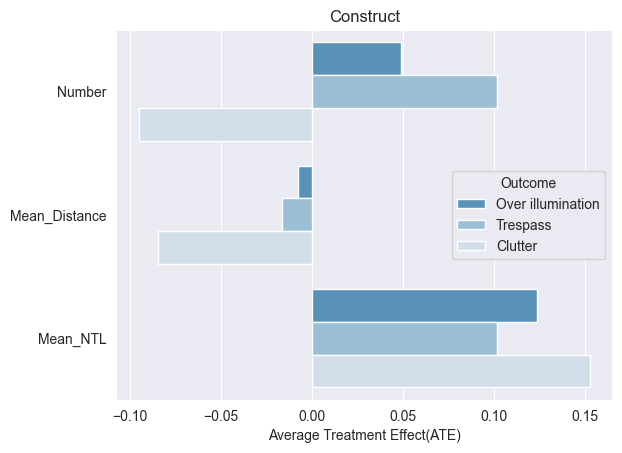

In [24]:
construct_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
construct_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
construct_effect = pd.melt(construct_effect, id_vars=["Treatment"], var_name = "Outcome")
construct_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = construct_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Construct")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("construct3.svg", bbox_inches = "tight")

In [25]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['industrial', 'industrial_mean_distance', 'industrial_mean_NTL']]].values)
T = scaler.fit_transform(data[['industrial', 'industrial_mean_distance', 'industrial_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "industrial"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,-0.089,0.052,-1.705,0.088,-0.174,-0.003,brownfield
1,0,Y1,-0.139,0.056,-2.485,0.013,-0.232,-0.047,brownfield
2,0,Y2,-0.018,0.105,-0.171,0.864,-0.191,0.155,brownfield
0,0,Y0,0.165,0.072,2.294,0.022,0.047,0.283,construction
1,0,Y1,0.187,0.088,2.119,0.034,0.042,0.333,construction
2,0,Y2,-0.027,0.131,-0.205,0.838,-0.242,0.189,construction
0,0,Y0,-0.202,0.069,-2.920,0.004,-0.315,-0.088,industrial
1,0,Y1,0.057,0.067,0.862,0.389,-0.052,0.167,industrial
2,0,Y2,0.243,0.110,2.203,0.028,0.062,0.425,industrial


In [26]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['grass', 'grass_mean_distance', 'grass_mean_NTL']]].values)
T = scaler.fit_transform(data[['grass', 'grass_mean_distance', 'grass_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary3 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary3.reset_index(inplace=True)

Summary3["Treatment"] = "grass"
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,1.414,0.065,21.757,0.000,1.307,1.520,grass
1,0,Y1,0.959,0.071,13.564,0.000,0.842,1.075,grass
2,0,Y2,0.276,0.149,1.849,0.065,0.030,0.521,grass


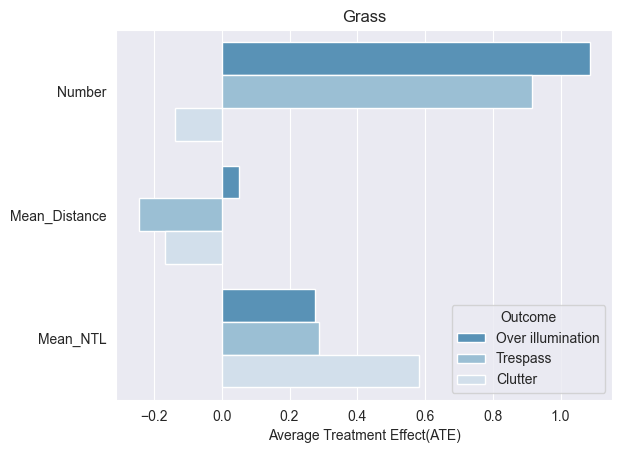

In [27]:
grass_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
grass_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
grass_effect = pd.melt(grass_effect, id_vars=["Treatment"], var_name = "Outcome")
grass_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = grass_effect,
    y = "Treatment", x = "value", hue = "Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title = "Grass")
plt.savefig("grass3.svg", bbox_inches = "tight")

In [28]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['farmland', 'farmland_mean_distance', 'farmland_mean_NTL']]].values)
T = scaler.fit_transform(data[['farmland', 'farmland_mean_distance', 'farmland_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "farmland"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,1.414,0.065,21.757,0.000,1.307,1.520,grass
1,0,Y1,0.959,0.071,13.564,0.000,0.842,1.075,grass
2,0,Y2,0.276,0.149,1.849,0.065,0.030,0.521,grass
0,0,Y0,-0.026,0.096,-0.272,0.786,-0.185,0.132,farmland
1,0,Y1,-0.012,0.134,-0.091,0.928,-0.232,0.208,farmland
2,0,Y2,0.109,0.138,0.787,0.432,-0.119,0.336,farmland


In [29]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['forest', 'forest_mean_distance', 'forest_mean_NTL']]].values)
T = scaler.fit_transform(data[['forest', 'forest_mean_distance', 'forest_mean_NTL', ]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "forest"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,1.414,0.065,21.757,0.000,1.307,1.520,grass
1,0,Y1,0.959,0.071,13.564,0.000,0.842,1.075,grass
2,0,Y2,0.276,0.149,1.849,0.065,0.030,0.521,grass
0,0,Y0,-0.026,0.096,-0.272,0.786,-0.185,0.132,farmland
1,0,Y1,-0.012,0.134,-0.091,0.928,-0.232,0.208,farmland
2,0,Y2,0.109,0.138,0.787,0.432,-0.119,0.336,farmland
0,0,Y0,0.303,0.144,2.108,0.035,0.067,0.540,forest
1,0,Y1,0.325,0.167,1.948,0.051,0.051,0.599,forest
2,0,Y2,0.083,0.191,0.434,0.664,-0.231,0.397,forest


In [30]:
Summary.loc[Summary["Y"]=="Y0", "Y"] = "Over Illumination"
Summary.loc[Summary["Y"]=="Y1", "Y"] = "Trespass"
Summary.loc[Summary["Y"]=="Y2", "Y"] = "Clutter"

Summary.rename(columns={"Y": "Outcome"}, inplace = True)

In [31]:
Summary2.loc[Summary2["Y"]=="Y0", "Y"] = "Over Illumination"
Summary2.loc[Summary2["Y"]=="Y1", "Y"] = "Trespass"
Summary2.loc[Summary2["Y"]=="Y2", "Y"] = "Clutter"

Summary2.rename(columns={"Y": "Outcome"}, inplace = True)

In [32]:
Summary3.loc[Summary3["Y"]=="Y0", "Y"] = "Over Illumination"
Summary3.loc[Summary3["Y"]=="Y1", "Y"] = "Trespass"
Summary3.loc[Summary3["Y"]=="Y2", "Y"] = "Clutter"

Summary3.rename(columns = {"Y": "Outcome"}, inplace = True)

In [33]:
Summarys = [Summary, Summary2, Summary3]

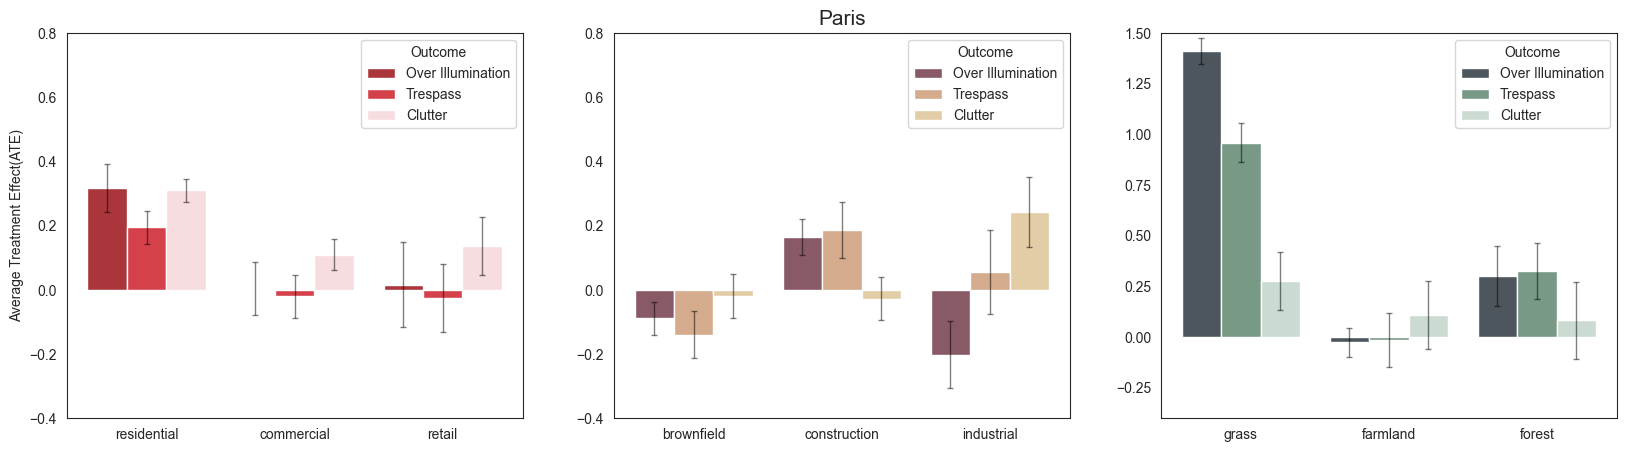

In [35]:
import pandas as pd
import seaborn as sns


# plt.figure(figsize = (20, 5))
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

flatui = ["#BD2329", "#EC2835", "#FCD7DD"]
sns.set_palette(flatui)

sns.barplot(
    data = Summary,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[0]
)

flatui = ["#8f5362", "#e0a981", "#ecd09c"]
sns.set_palette(flatui)

axes[1] = sns.barplot(
    data = Summary2,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[1]
)

# flatui = ["#79b4a0", "#a3c8a4", "#d4daa1"]
# sns.set_palette(flatui)

flatui = ["#4A565F", "#719F85", "#CADDD1"]
sns.set_palette(flatui)

axes[2] = sns.barplot(
    data = Summary3,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[2]
)

for index in range(3):
    x = Summarys[index]["Treatment"]
    y = Summarys[index]["point_estimate"]
    yerr = Summarys[index]["stderr"]
    
    bars = [c for c in axes[index].get_children() if isinstance(c, matplotlib.patches.Rectangle)]
    bars = bars[:-1]
    
    for i, bar in enumerate(bars):
            height = bar.get_height()
            x_pos = bar.get_x() + bar.get_width() / 2
            axes[index].errorbar(x = x_pos, y = height, yerr = yerr.iloc[i], fmt = 'none', capsize = 2, color = 'black', elinewidth = 1, alpha = 0.5)

# plt.savefig("ATE2.svg", bbox_inches = "tight")
axes[0].set(xlabel = '', ylabel = "Average Treatment Effect(ATE)")

# axes[0].legend().set_visible(False)
# axes[1].legend().set_visible(False)

axes[1].set(xlabel = '', ylabel = "")
axes[0].set_ylim([-0.4, 0.8])
axes[1].set_ylim([-0.4, 0.8])
axes[1].set_title("Paris", fontsize = 15)
axes[2].set_ylim([-0.4, 1.5])
axes[2].set(xlabel = '', ylabel = "")

plt.savefig("ATE_Paris.svg", bbox_inches = "tight")